In [46]:
from os import listdir
import cv2
from typing import List
import random
import numpy as np

In [47]:
%matplotlib inline
import matplotlib.pyplot as plt

In [48]:
import torch
from torch import optim, nn
from torch.utils.data import DataLoader, random_split
from torchvision.utils import make_grid
from torchvision import models, transforms, datasets

In [49]:
# Set device.
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

### CONFIG

In [50]:
# Hyperparameters.
learning_rate = 1e-3
batch_size = 128
num_epochs = 50
train_split = 0.7
image_size = (224, 224)
num_workers = 2


In [51]:
# Load data.
datasets_info = {
    "WLASL": {"name": "WLASL_frames_100", "path": "WLASL/frames_100"},
    "animals": {"name": "animals_simple", "path": "animals/simple"},
}


dataset_name = "WLASL"
data_dir = f"../../data/{datasets_info[dataset_name]['path']}"


### Input labels with images

In [52]:
input_labels = listdir(data_dir)
input_labels[:5]

['accident', 'africa', 'all', 'apple', 'basketball']

In [53]:
def show_image(img):
  img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
  plt.imshow(img)
  plt.show()
  
def imshow(img):
  img = img / 2 + 0.5 # unnormalize
  npimg = img.numpy() # convert to numpy objects
  plt.imshow(np.transpose(npimg, (1, 2, 0)))
  plt.show()

go


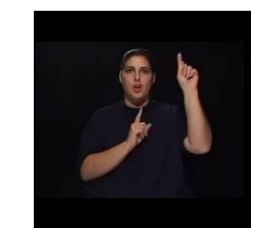

In [54]:
label = input_labels[random.randint(0, len(input_labels) - 1)]
label_images = listdir(data_dir + "/" + label)
label_images

print(label)

image = cv2.imread(data_dir + "/" + label + "/" + label_images[0])
show_image(image)


### Create dataloader for pytorch

In [55]:
from torch.utils.data.sampler import SubsetRandomSampler


### Using random_split

In [56]:
def load_split_dataset(data_dir, train_split=0.7, batch_size=32, image_size=224):
    transform = transforms.Compose(
        [
            transforms.Resize(image_size),
            transforms.CenterCrop(image_size-10),
            transforms.ToTensor(),
        ]
    )
    dataset = datasets.ImageFolder(data_dir, transform=transform)

    classes = dataset.classes
    dataset_len = len(dataset)

    train_split = int(train_split * dataset_len)
    tets_split = dataset_len - train_split
    train_set, test_set = random_split(dataset, [train_split, tets_split])

    train_loader = DataLoader(
        dataset=train_set, batch_size=batch_size, shuffle=True, num_workers=num_workers
    )
    test_loader = DataLoader(
        dataset=test_set, batch_size=batch_size, shuffle=True, num_workers=num_workers
    )

    return train_loader, test_loader, classes


### Solution to unbalanced labels 1: Random dataset split to solve unbalanced labels

In [57]:
def load_split_dataset(data_dir, train_split=0.7, batch_size=32, image_size=224):
    transform = transforms.Compose(
        [
            transforms.Resize(image_size),
            transforms.ToTensor(),
        ]
    )
    dataset = datasets.ImageFolder(data_dir, transform=transform)

    classes = dataset.classes
    dataset_len = len(dataset)

    ran_ind = torch.randperm(dataset_len)  # 1. random
    # seq_ind = list(range(dataset_len))  # 2. sequential

    indices = ran_ind
    split = int(np.floor(train_split * dataset_len))
    train_indices, test_indices = indices[:split], indices[split:]

    train_sampler = SubsetRandomSampler(train_indices)
    test_sampler = SubsetRandomSampler(test_indices)

    train_loader = DataLoader(
        dataset,
        sampler=train_sampler,
        batch_size=batch_size,
        num_workers=num_workers,
    )
    test_loader = DataLoader(
        dataset,
        sampler=test_sampler,
        batch_size=batch_size,
        num_workers=num_workers,
    )

    return train_loader, test_loader, classes


### Uso del dataset

In [58]:
train_loader, test_loader, classes = load_split_dataset(
    data_dir,
    train_split=train_split,
    batch_size=batch_size,
    image_size=image_size,
)

num_classes = len(classes)

print(len(train_loader))
print(len(test_loader))
print(train_loader.batch_size)

34
15
128


### Check how many images are in each loader for every label

In [59]:
def check_balance_status(loader):
    class_count = {}

    for _, targets in loader:
        for target in targets:
            label = classes[target]
            if label not in class_count:
                class_count[label] = 0
            class_count[label] += 1

    return sorted(class_count.items())


train_class_count = check_balance_status(train_loader)
test_class_count = check_balance_status(test_loader)

pc_mean = 0

for tr, te in zip(train_class_count, test_class_count):
    tr_pc = tr[1] / (tr[1] + te[1]) * 100
    pc_mean += tr_pc
    print(f"{tr[0]} - TR: {tr[1]} TS: {te[1]} - PC-TR: {tr_pc:.2f}%")
    
pc_mean /= len(train_class_count)
print(f"Mean PC-TR: {pc_mean:.2f}%")


accident - TR: 44 TS: 13 - PC-TR: 77.19%
africa - TR: 43 TS: 11 - PC-TR: 79.63%
all - TR: 45 TS: 18 - PC-TR: 71.43%
apple - TR: 45 TS: 12 - PC-TR: 78.95%
basketball - TR: 37 TS: 17 - PC-TR: 68.52%
bed - TR: 39 TS: 21 - PC-TR: 65.00%
before - TR: 53 TS: 25 - PC-TR: 67.95%
bird - TR: 39 TS: 18 - PC-TR: 68.42%
birthday - TR: 36 TS: 18 - PC-TR: 66.67%
black - TR: 46 TS: 17 - PC-TR: 73.02%
blue - TR: 38 TS: 22 - PC-TR: 63.33%
book - TR: 90 TS: 30 - PC-TR: 75.00%
bowling - TR: 43 TS: 17 - PC-TR: 71.67%
brown - TR: 40 TS: 14 - PC-TR: 74.07%
but - TR: 36 TS: 18 - PC-TR: 66.67%
can - TR: 40 TS: 20 - PC-TR: 66.67%
candy - TR: 47 TS: 25 - PC-TR: 65.28%
chair - TR: 56 TS: 22 - PC-TR: 71.79%
change - TR: 38 TS: 19 - PC-TR: 66.67%
cheat - TR: 33 TS: 21 - PC-TR: 61.11%
city - TR: 39 TS: 15 - PC-TR: 72.22%
clothes - TR: 53 TS: 22 - PC-TR: 70.67%
color - TR: 45 TS: 12 - PC-TR: 78.95%
computer - TR: 65 TS: 25 - PC-TR: 72.22%
cook - TR: 35 TS: 19 - PC-TR: 64.81%
cool - TR: 45 TS: 18 - PC-TR: 71.43%
corn 

### Load pretrained resnet model

In [60]:
# Load pretrain model & modify it.
model = models.resnet50(pretrained=True)

In [61]:
for param in model.parameters():
    param.requires_grad = False

model.fc = nn.Sequential(
    nn.Linear(2048, 512),
    nn.ReLU(),
    nn.Dropout(0.2),
    nn.Linear(512, num_classes),
    nn.LogSoftmax(dim=1),
)


In [62]:
# Loss and optimizer.
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.fc.parameters(), lr=learning_rate)

model.to(device)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

### Freeze model and train only last layer

In [63]:
def train():
    # Train network.
    costs = []

    for epoch in range(num_epochs):
        losses = []

        for batch_idx, (data, targets) in enumerate(train_loader):
            # Get data to cuda if possible.
            data = data.to(device)
            targets = targets.to(device)

            # forward.
            scores = model(data)
            loss = criterion(scores, targets)
            losses.append(loss.item())

            # backward.
            optimizer.zero_grad()
            loss.backward()

            # gradient descent or adam step.
            optimizer.step()

        cost = sum(losses) / len(losses)
        costs.append(cost)
        print(f"Cost at epoch {epoch + 1} is {cost:.5f}")

    return costs


costs = train()


Cost at epoch 1 is 4.61423
Cost at epoch 2 is 4.46029
Cost at epoch 3 is 4.28346
Cost at epoch 4 is 4.07454
Cost at epoch 5 is 3.88135
Cost at epoch 6 is 3.70616
Cost at epoch 7 is 3.55626
Cost at epoch 8 is 3.39919
Cost at epoch 9 is 3.28906
Cost at epoch 10 is 3.16640
Cost at epoch 11 is 3.05093
Cost at epoch 12 is 2.96041
Cost at epoch 13 is 2.87157
Cost at epoch 14 is 2.76858
Cost at epoch 15 is 2.69357
Cost at epoch 16 is 2.58732
Cost at epoch 17 is 2.53551
Cost at epoch 18 is 2.48650
Cost at epoch 19 is 2.40368
Cost at epoch 20 is 2.38070
Cost at epoch 21 is 2.29428
Cost at epoch 22 is 2.23938
Cost at epoch 23 is 2.17056
Cost at epoch 24 is 2.11609
Cost at epoch 25 is 2.05521
Cost at epoch 26 is 1.98883
Cost at epoch 27 is 1.97157
Cost at epoch 28 is 1.94075
Cost at epoch 29 is 1.89772
Cost at epoch 30 is 1.85971
Cost at epoch 31 is 1.81778
Cost at epoch 32 is 1.74537
Cost at epoch 33 is 1.71830
Cost at epoch 34 is 1.70542
Cost at epoch 35 is 1.63600
Cost at epoch 36 is 1.64379
C

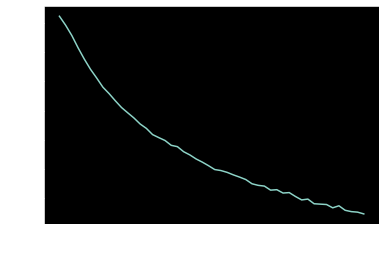

In [64]:
def plot_costs(costs):
    # Plot cost.
    plt.plot(costs)
    plt.ylabel("Cost")
    plt.xlabel("Epoch")
    plt.show()


plot_costs(costs)


### Save model

In [68]:
model_name = datasets_info[dataset_name]["name"]
model_path = f"../../models/resnet_{model_name}.pth"

In [69]:
# Export model.
torch.save(model, model_path)


### Load saved model

In [70]:
# Import model for acc test.
model = torch.load(model_path)
model.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

### Test net

In [71]:
# Check accuracy on training & test to see how good our model predicts.
def check_accuracy(loader, model):
    num_correct = 0
    num_samples = 0
    model.eval()

    with torch.no_grad():
        for i, (x, y) in enumerate(loader):
            x, y = x.to(device), y.to(device)

            scores = model(x)
            _, predictions = scores.max(1)
            num_correct += (predictions == y).sum()
            num_samples += predictions.size(0)

            # Output both images to compare.
            print(f"Images for {i+1}")
            imshow(make_grid(x.cpu()))

            print(f"Predictions for batch {i+1} ")
            print([classes[int(i)] for i in predictions])

            print(f"Ground truth for batch {i+1}")
            print([classes[int(i)] for i in y])
            
            print("---------------------------------\n\n")
            break

        print(
            f"Got {num_correct} / {num_samples} with accuracy {float(num_correct)/float(num_samples)*100:.2f}"
        )


Checking accuracy on Training Set
Images for 1


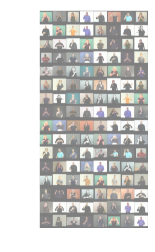

Predictions for batch 1 
['thanksgiving', 'accident', 'book', 'cousin', 'apple', 'man', 'cool', 'book', 'give', 'right', 'jacket', 'black', 'time', 'tall', 'africa', 'cow', 'drink', 'chair', 'wrong', 'same', 'what', 'hat', 'clothes', 'go', 'year', 'jacket', 'short', 'chair', 'basketball', 'white', 'help', 'can', 'cook', 'what', 'hot', 'purple', 'same', 'birthday', 'woman', 'before', 'give', 'blue', 'cool', 'man', 'thin', 'yes', 'finish', 'clothes', 'yes', 'cow', 'pink', 'drink', 'family', 'finish', 'jacket', 'now', 'accident', 'tell', 'cook', 'hearing', 'shirt', 'jacket', 'same', 'computer', 'brown', 'hat', 'apple', 'wrong', 'hearing', 'need', 'walk', 'africa', 'walk', 'before', 'apple', 'later', 'yes', 'apple', 'city', 'mother', 'pink', 'pink', 'woman', 'candy', 'apple', 'language', 'forget', 'language', 'chair', 'but', 'bowling', 'full', 'year', 'fish', 'enjoy', 'dog', 'full', 'can', 'play', 'computer', 'hot', 'deaf', 'book', 'purple', 'need', 'cow', 'enjoy', 'fine', 'who', 'same', '

In [72]:
print("Checking accuracy on Training Set")
check_accuracy(train_loader, model)


Checking accuracy on Test Set
Images for 1


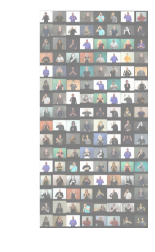

Predictions for batch 1 
['go', 'give', 'secretary', 'blue', 'computer', 'later', 'before', 'but', 'cousin', 'book', 'computer', 'same', 'computer', 'yes', 'dark', 'black', 'give', 'apple', 'color', 'tell', 'black', 'what', 'dog', 'chair', 'chair', 'same', 'computer', 'how', 'time', 'decide', 'jacket', 'blue', 'paper', 'finish', 'meet', 'orange', 'black', 'hat', 'city', 'who', 'orange', 'no', 'tall', 'what', 'hat', 'tall', 'go', 'decide', 'cool', 'hearing', 'yes', 'study', 'kiss', 'tell', 'later', 'fine', 'before', 'kiss', 'school', 'later', 'many', 'forget', 'paper', 'deaf', 'letter', 'forget', 'full', 'dog', 'deaf', 'mother', 'thursday', 'drink', 'paper', 'doctor', 'who', 'tall', 'want', 'blue', 'basketball', 'bowling', 'paper', 'medicine', 'cook', 'doctor', 'give', 'letter', 'no', 'bird', 'year', 'table', 'tell', 'computer', 'study', 'book', 'play', 'corn', 'table', 'brown', 'study', 'chair', 'finish', 'same', 'tell', 'computer', 'thanksgiving', 'work', 'brown', 'book', 'yes', 'brow

In [73]:
print("Checking accuracy on Test Set")
check_accuracy(test_loader, model)

### Check train and test on same class.

In [74]:
def predict_class(loader, model, debug_label):

    for images, targets in loader:
        images, targets = images.to(device), targets.to(device)

        scores = model(images)
        _, predictions = scores.max(1)

        for i, (image, target) in enumerate(zip(images, targets)):
            label = classes[target]
            if label != debug_label:
                continue

            # Predict label for image.
            prediction_id = predictions[i]
            prediction = classes[prediction_id]

            # Show image.
            imshow(image.cpu())

            print(f"Prediction: {prediction}. Ground truth: {label}")

            return

    return sorted(class_count.items())


In [75]:
debug_label = "horse"


In [76]:
print(f"Prediction for {debug_label} and train set")
predict_class(train_loader, model, debug_label)


Prediction for horse and train set


NameError: name 'class_count' is not defined

Prediction for horse and test set


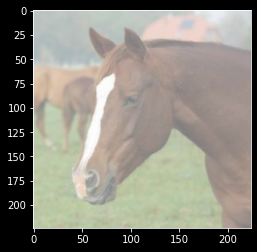

Prediction: horse. Ground truth: horse


In [ ]:
print(f"Prediction for {debug_label} and test set")
predict_class(test_loader, model, debug_label)
